# Submodule 3: Taxonomic Classification and Diversity Analysis

## Overview

The module focuses on analyzing 16S rRNA sequencing data to explore the composition and diversity of the gut microbiome. The module begins with importing and integrating survey-based metadata, followed by assigning taxonomy to sequencing reads using the phyloseq package. Key concepts such as rarefaction, alpha diversity (e.g., Shannon and Inverse Simpson indices), and beta diversity (e.g., Bray-Curtis NMDS) are introduced to assess microbial diversity within and between samples. Visualizations and statistical analyses are used to examine the relationships between microbiome composition and variables like protein intake, sex, and BMI. Through hands-on exercises, learners gain practical experience in microbiome data processing, visualization, and interpretation, building a strong foundation for future research.

<center>
    <img src="images/3.JPEG" alt="2"/>
</center>

## Learning Objectives
+ Perform taxonomic classification of 16S rRNA sequences
+ Evaluate and explore rarefaction curves to assess sampling depth and species richness
+ Analyze alpha and beta diversity within microbial communities


# 1. Import Data

### Files
 
 1. **Food Frequency Questionnaire (FFQ):**
    - This CSV file contains data from a food frequency questionnaire completed by study participants. It includes columns for participant identifiers (e.g., SampleID), demographic information (e.g., SEX, AGE), and food consumption frequencies and quantities (e.g., BREAKFASTSANDWICHFREQ, EGGSFREQ). This data will allow us to analyze dietary habits and link them with microbiome profiles.
 2. **Lifestyle Questionnaire:**
    - This text file contains responses to lifestyle questions, such as physical activity levels, smoking status, and other lifestyle factors. It has a row for each question, an answer key, and responses for individual participants in columns.
   
 3.  **FASTQ Files:**
    - These files contain raw sequencing data from 16S rRNA sequencing. Each read in a FASTQ file has a sequence identifier, nucleotide sequence, and quality scores. 

Let's start by loading the survey files into DataFrames and performing some initial quality checks to ensure data integrity.

## Import Survey Data

### Step 1: Load the Survey Data
Let's load both survey files:

In [ ]:
# Install and load required packages
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
    install.packages("ggplot2")
}

if (!requireNamespace("vegan", quietly = TRUE)) {
    install.packages("vegan")
}

if (!requireNamespace("ggpubr", quietly = TRUE)) {
    install.packages("ggpubr")
}


In [1]:
library("dplyr")
library("ggplot2")
library("vegan")
library("ggpubr")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice



In [3]:
#Load in the data
ffq <- read.csv("metadata/FFQ_Data.csv")
lsq <- read.csv("metadata/MetaData.txt", sep = '\t')
# Display the first few rows of the dataframe to understand its structure
head(ffq)

,SampleID,RESPONDENTID,BOOKNUM,SEX,PREGNANT,AGE,WEIGHT,HEIGHTFEET,HEIGHTINCHES,BREAKFASTSANDWICHFREQ,⋯,DT_FIBER_INSOL,DT_FIBER_SOL,DT_PROT_ANIMAL,DT_PROT_VEGETABLE,DT_NITROGEN,PHYTIC_ACID,OXALIC_ACID,COUMESTROL,BIOCHANIN_A,FORMONONETIN
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WP_J06MK,1,18980,1,M,34,241,5,9,2,⋯,6.00,2.19,47.58,11.57,9.51,232.61,116.65,0.0172,0.0552,0.00961
2,WP_SUFNU,2,18979,2,1,36,120,5,2,4,⋯,5.27,2.17,32.72,11.72,7.13,262.80,87.68,0.0177,0.0625,0.00812
3,WP_1VMLX,4,18978,1,M,20,130,5,5,4,⋯,5.39,2.34,29.91,14.25,7.13,337.39,77.20,0.0364,0.0311,0.00282
4,WP_J0B3X,5,18976,1,3,27,175,6,0,6,⋯,14.85,5.82,55.14,31.85,14.11,724.34,168.53,0.0250,0.0670,0.01110
5,WP_RAJES,6,18977,2,1,57,140,5,1,2,⋯,9.35,3.41,26.85,13.96,6.54,281.76,133.80,0.0179,0.0910,0.01850
6,WP_G9EBL,7,18971,1,3,56,150,5,8,2,⋯,17.18,5.07,35.75,29.76,10.86,765.78,330.54,0.1690,0.0970,0.02390


Our Food Frequency Questionaire has columns representing the Sample ID, Respondent ID number, and all the questions asked. The heading of the columns represents abbreviations for the questions. Now let's look at the dimensions of our data.

In [ ]:
# Full dimensions
dim(ffq)
# Number of row
nrow(ffq)
# Number of columns
ncol(ffq)

We can see that we have 100 participants (every row is a sample) and 1074 columns which means over 1000 food questions! Now let's look at the lifestyle survey. 

In [ ]:
# Display the first few rows of the dataframe to understand its structure
head(lsq)

Our Lifestyle Questionaire has columns representing the Sample ID and all the lifestyle questions asked. The heading of the columns represents abbreviations for the questions. Now let's look at the dimensions of our data.

In [ ]:
# Full dimensions
dim(lsq)
# Number of row
nrow(lsq)
# Number of columns
ncol(lsq)

We have less questions in this survey, only 33, and 96 participants.

### Step 2: Quick Quality Control Checks
Let's perform several initial checks to assess data quality:

 1. **Collect Intersection of Samples:** We need to find the Sample IDs in the FFQ data rows and in the LSQ data columns. 


In [5]:
# Find sample intersection
samples <- intersect(ffq$SampleID, lsq$SampleID)

In [7]:
length(samples)

[1] 96

 2. **Basic Summary Statistics:** We can get an overview of the data, which can help identify outliers or unexpected values. We will look at the demographic questions in the FFQ and Lifestyle Questionnaire separately.

In [ ]:
# Summary statistics for the first 10 columns
summary(ffq[, 1:9])


In [ ]:
# Summary statistics for 3 columns
summary(lsq[, 3:5])


3. **Visualize Data:** Ensure the data looks accurate with exploratory visualizations.

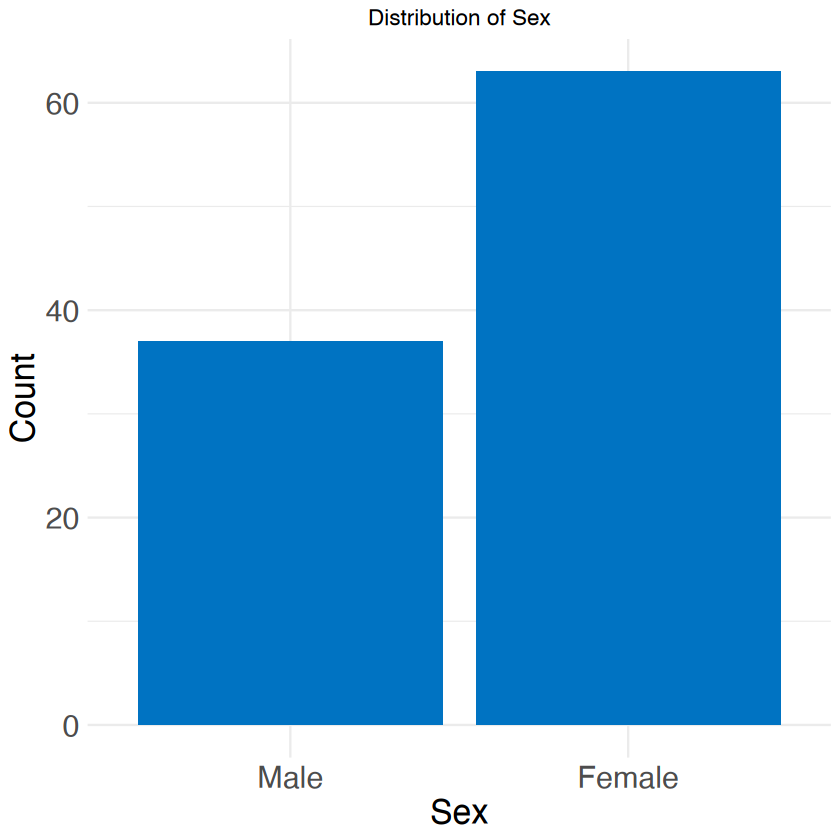

In [9]:
# Load necessary library
library(ggplot2)

# Set up the plotting theme
theme_set(theme_minimal())

# 1. Bar plot for Sex distribution
# Bar plot for Sex distribution without modifying the original data
ggplot(ffq, aes(x = factor(SEX, levels = c(1, 2), labels = c("Male", "Female")))) +
  geom_bar(fill = "#0073C2FF") +  # Blue color for bars
  labs(title = "Distribution of Sex", x = "Sex", y = "Count") +
  theme(plot.title = element_text(hjust = 0.5), axis.title = element_text(size = 20),
    axis.text = element_text(size = 18))


In [ ]:
ggplot(lsq, aes(x = factor(Sex))) +
  geom_bar(fill = "#0073C2FF") +  # Blue color for bars
  labs(title = "Distribution of Sex", x = "Sex", y = "Count") +
  theme(plot.title = element_text(hjust = 0.5), axis.title = element_text(size = 20),
        axis.text = element_text(size = 18))


In [ ]:
# 2. Histogram for Age distribution
# Dropping NA values for AGE
ggplot(ffq, aes(x = AGE)) +
  geom_histogram(bins = 10, fill = "lightgreen", color = "black") +
  labs(title = "Age Distribution", x = "Age", y = "Frequency") +
  theme(plot.title = element_text(hjust = 0.5), axis.title = element_text(size = 20),
    axis.text = element_text(size = 18))


In [ ]:
ggplot(lsq, aes(x = Age)) +
  geom_histogram(bins = 10, fill = "lightgreen", color = "black") +
  labs(title = "Age Distribution", x = "Age", y = "Frequency") +
  theme(plot.title = element_text(hjust = 0.5), axis.title = element_text(size = 20),
        axis.text = element_text(size = 18))

In [ ]:
# 3. Histogram for Weight distribution
# Dropping NA values for WEIGHT
ggplot(ffq, aes(x = WEIGHT)) +
  geom_histogram(bins = 15, fill = "lightcoral", color = "black") +
  labs(title = "Weight Distribution", x = "Weight", y = "Frequency") +
  theme(plot.title = element_text(hjust = 0.5), axis.title = element_text(size = 20),
    axis.text = element_text(size = 18))

In [ ]:
ggplot(lsq, aes(x = Weight)) +
  geom_histogram(bins = 15, fill = "lightcoral", color = "black") +
  labs(title = "Weight Distribution", x = "Weight", y = "Frequency") +
  theme(plot.title = element_text(hjust = 0.5), axis.title = element_text(size = 20),
        axis.text = element_text(size = 18))


### Step 3: Combine Metadata

We have two different surveys, let's combine them into one so we only have one metadata file to work with. 

In [11]:
# Load in data from Submodule 2
sample.names <- readRDS('sampleNames.rds')
taxa         <- readRDS("taxa.rds")
reads        <- readRDS("seqtabnochim.rds")

In [13]:
# Merge data
metadata <- merge(ffq, lsq, by = "SampleID", all = TRUE)
# Rename samples to match FastQ files
metadata$SampleID <- gsub("WP_", "WP-", metadata$SampleID)

We have a lot more samples in our metadata than we do sequenced, therefore we need to pull out only the samples who have sequenced reads from our metadata.

In [16]:
# Add in only if they have sequences
dfseqIndo <- data.frame(sampleNames = sample.names,
                       inSeq       = rep('yes', length(sample.names)))
# Only keep those who do
metadata <- merge(dfseqIndo, metadata, by.x = 'sampleNames', by.y = 'SampleID', all.x = TRUE)
colnames(metadata)[1] <- 'SampleID'
rownames(metadata)    <- metadata$SampleID

In [18]:
dim(metadata)

[1]   35 1107

We now have 35 samples with metadata and sequenced reads.

When merging metadata from two different surveys, it is common to encounter discrepancies due to human error, such as participants providing slightly different responses across surveys for variables like age or weight. While these inconsistencies highlight the importance of careful data handling, for this analysis, we will rely on the FFQ data as it is more standardized and consistent. 

In [21]:
# Flag discrepancies and missing data
discrepancies <- metadata %>%
  mutate(
    age_discrepancy = ifelse(Age != AGE, TRUE, FALSE),
    weight_discrepancy = ifelse(Weight != WEIGHT, TRUE, FALSE)
  )


# Summarize discrepancies and missing data
summary <- data.frame(
  age_discrepancy = sum(discrepancies$age_discrepancy, na.rm = TRUE),
  weight_discrepancy = sum(discrepancies$weight_discrepancy, na.rm = TRUE)
)

summary

age_discrepancy,weight_discrepancy
<int>,<int>
9,4


Our data shows some inconsistencies. We will use the FFQ data, as it is a standardized survey. Now, let's examine our data more by creating a table to get an overview of our data by sex and BMI.

In [24]:
# Order BMI
metadata$BMI_ordinal = factor(metadata$BMI_ordinal, levels = c('Healthy weight', 'Overweight', 'Obese'))

In [26]:
# Group data by Sex
table1 <- metadata %>%
  group_by(Sex) %>%
  summarize(
    Count = n(),
    Mean_Age = mean(AGE, na.rm = TRUE),
    Mean_Weight = mean(WEIGHT, na.rm = TRUE),
    Mean_Height = mean(Height, na.rm = TRUE),
    Mean_BMI = mean(BMI, na.rm = TRUE),
    Mean_Num_Animals = mean(num_animals, na.rm = TRUE),
    Mean_Kcal = mean(DT_KCAL, na.rm = TRUE),
    Mean_Protein = mean(DT_PROT, na.rm = TRUE),
    Mean_Carbohydrate = mean(DT_CARB, na.rm = TRUE),
    Mean_Fat = mean(DT_TFAT, na.rm = TRUE),
    Mean_Alcohol = mean(DT_ALCO, na.rm = TRUE),
    Mean_Sugars = mean(DT_SUG_T, na.rm = TRUE),
    Mean_Fiber = mean(DT_FIBE, na.rm = TRUE)
  )

# View the table
table1

Sex,Count,Mean_Age,Mean_Weight,Mean_Height,Mean_BMI,Mean_Num_Animals,Mean_Kcal,Mean_Protein,Mean_Carbohydrate,Mean_Fat,Mean_Alcohol,Mean_Sugars,Mean_Fiber
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,19,35.68421,142.2105,64.65789,24.04154,0.9473684,1628.890,63.23263,170.3863,77.63474,5.422737,71.94737,19.32947
Male,16,35.25000,179.1875,69.53125,26.23651,1.2500000,1904.751,73.14813,211.3044,75.63938,18.270063,86.78562,19.96000


In [ ]:
# Group data by BMI
table2 <- metadata %>%
  group_by(BMI_ordinal) %>%
  summarize(
    Count = n(),
    Mean_Age = mean(AGE, na.rm = TRUE),
    Mean_Weight = mean(WEIGHT, na.rm = TRUE),
    Mean_Height = mean(Height, na.rm = TRUE),
    Male_Percent = mean(SEX == 1, na.rm = TRUE) * 100,
    Female_Percent = mean(SEX == 2, na.rm = TRUE) * 100,
    Mean_Num_Animals = mean(num_animals, na.rm = TRUE),
    Mean_Kcal = mean(DT_KCAL, na.rm = TRUE),
    Mean_Protein = mean(DT_PROT, na.rm = TRUE),
    Mean_Carbohydrate = mean(DT_CARB, na.rm = TRUE),
    Mean_Fat = mean(DT_TFAT, na.rm = TRUE),
    Mean_Alcohol = mean(DT_ALCO, na.rm = TRUE),
    Mean_Sugars = mean(DT_SUG_T, na.rm = TRUE),
    Mean_Fiber = mean(DT_FIBE, na.rm = TRUE)
  )

# View the table
table2

Let's now categorize dietary intake so we can eaisly view differences.

In [29]:
# Create metadata variables with levels based on dietary standards
metadata <- metadata %>%
  mutate(
    # Calories (kcal/day, general range: 1500-3000 for adults)
    Kcal_Level = case_when(
      DT_KCAL < 1500 ~ "Low",
      DT_KCAL >= 1500 & DT_KCAL <= 3000 ~ "Moderate",
      DT_KCAL > 3000 ~ "High",
      TRUE ~ NA_character_
    ),
    
    # Protein (g/day, general range: 46-56 g for adults)
    Protein_Level = case_when(
      DT_PROT < 46 ~ "Low",
      DT_PROT >= 46 & DT_PROT <= 56 ~ "Moderate",
      DT_PROT > 56 ~ "High",
      TRUE ~ NA_character_
    ),
    
    # Carbohydrates (g/day, general range: 225-325 g based on 2000 kcal diet)
    Carb_Level = case_when(
      DT_CARB < 225 ~ "Low",
      DT_CARB >= 225 & DT_CARB <= 325 ~ "Moderate",
      DT_CARB > 325 ~ "High",
      TRUE ~ NA_character_
    ),
    
    # Total Fat (g/day, general range: 44-77 g based on 2000 kcal diet)
    Fat_Level = case_when(
      DT_TFAT < 44 ~ "Low",
      DT_TFAT >= 44 & DT_TFAT <= 77 ~ "Moderate",
      DT_TFAT > 77 ~ "High",
      TRUE ~ NA_character_
    ),
    
    # Dietary Fiber (g/day, general recommendation: 25-38 g)
    Fiber_Level = case_when(
      DT_FIBE < 25 ~ "Low",
      DT_FIBE >= 25 & DT_FIBE <= 38 ~ "Moderate",
      DT_FIBE > 38 ~ "High",
      TRUE ~ NA_character_
    ),
    
    
    # Categorize alcohol intake
    Alcohol_Level = case_when(
      DT_ALCO == 0 ~ "No Alcohol",
      DT_ALCO > 0 & DT_ALCO <= 14 ~ "Low",
      DT_ALCO > 14 & DT_ALCO <= 30 ~ "Moderate",
      DT_ALCO > 30 ~ "High",
      TRUE ~ NA_character_
    ),
    
    # Categorize sugar intake
    Sugar_Level = case_when(
      DT_SUG_T <= 25 ~ "Low",
      DT_SUG_T > 25 & DT_SUG_T <= 50 ~ "Moderate",
      DT_SUG_T > 50 ~ "High",
      TRUE ~ NA_character_
    )
  )


# Reorder Fiber_Level
metadata$Fiber_Level <- factor(metadata$Fiber_Level, levels = c("Low", "Moderate", "High"))

# Reorder Alcohol_Level
metadata$Alcohol_Level <- factor(metadata$Alcohol_Level, levels = c("No Alcohol", "Low", "Moderate", "High"))

# Reorder Sugar_Level
metadata$Sugar_Level <- factor(metadata$Sugar_Level, levels = c("Low", "Moderate", "High"))


# Reorder Kcal_Level
metadata$Kcal_Level <- factor(metadata$Kcal_Level, levels = c("Low", "Moderate", "High"))

# Reorder Protein_Level
metadata$Protein_Level <- factor(metadata$Protein_Level, levels = c("Low", "Moderate", "High"))

# Reorder Carbohydrate_Level
metadata$Carb_Level <- factor(metadata$Carb_Level, levels = c("Low", "Moderate", "High"))

# Reorder Fat_Level
metadata$Fat_Level <- factor(metadata$Fat_Level, levels = c("Low", "Moderate", "High"))

# Treat the number of animals as discrete not continuous
metadata$num_animals = factor(metadata$num_animals, levels = c('0', '1', '2', '3', '4'))


Let's view the distribution of our `Protein_Level`.

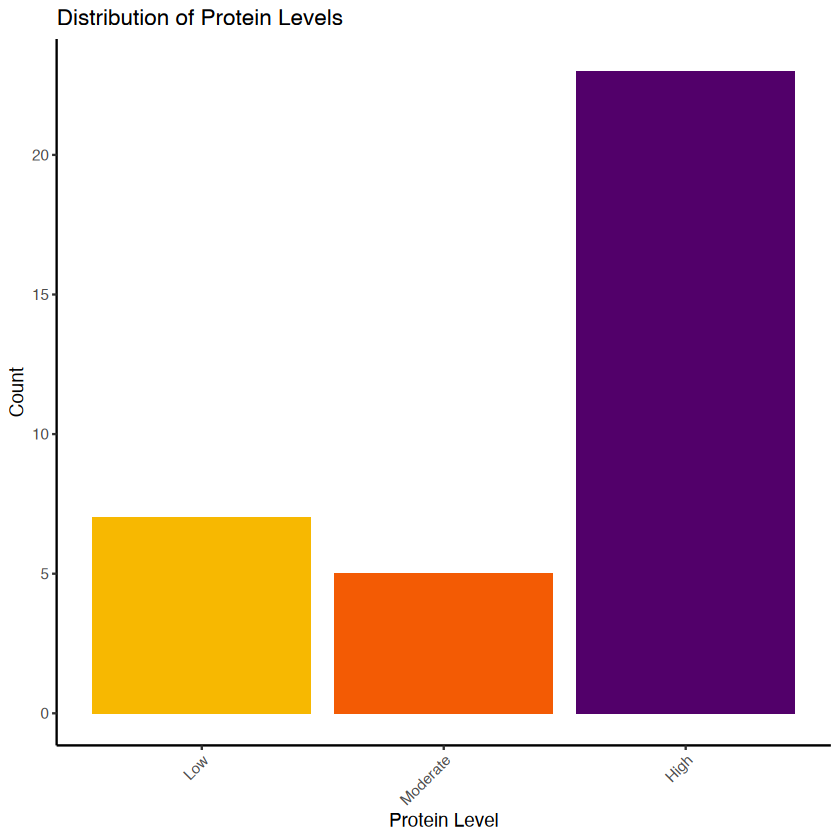

In [32]:
ggplot(metadata, aes(x = Protein_Level, fill = Protein_Level)) +
  geom_bar() +
  theme_classic() +
  labs(
    title = "Distribution of Protein Levels",
    x = "Protein Level",
    y = "Count"
  ) +
  scale_fill_manual(values = c('Low' = '#f7b801',  
                                'Moderate' = '#f35b04', 
                                'High' = '#52006A')) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "none"
  )

Let's view protein intake by sex.

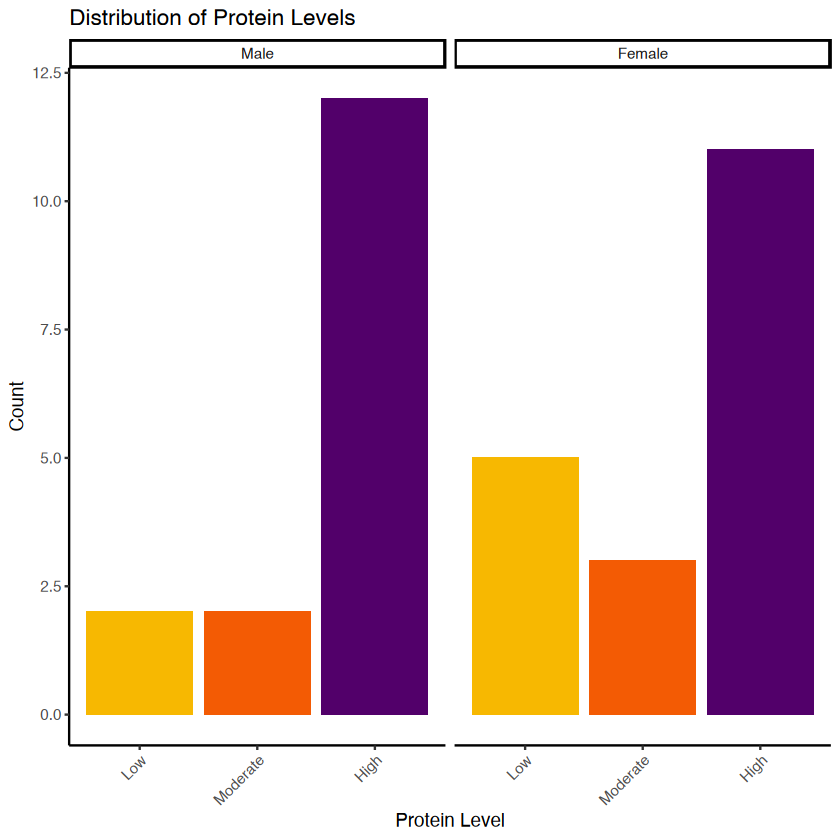

In [35]:
ggplot(metadata, aes(x = Protein_Level, fill = Protein_Level)) +
  geom_bar() +
  theme_classic() +
  labs(
    title = "Distribution of Protein Levels",
    x = "Protein Level",
    y = "Count"
  ) +
  scale_fill_manual(values = c('Low' = '#f7b801',  
                                'Moderate' = '#f35b04', 
                                'High' = '#52006A')) +
  facet_wrap(~SEX, labeller = as_labeller(c("1" = "Male", "2" = "Female"))) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "none"
  )

And now by BMI.

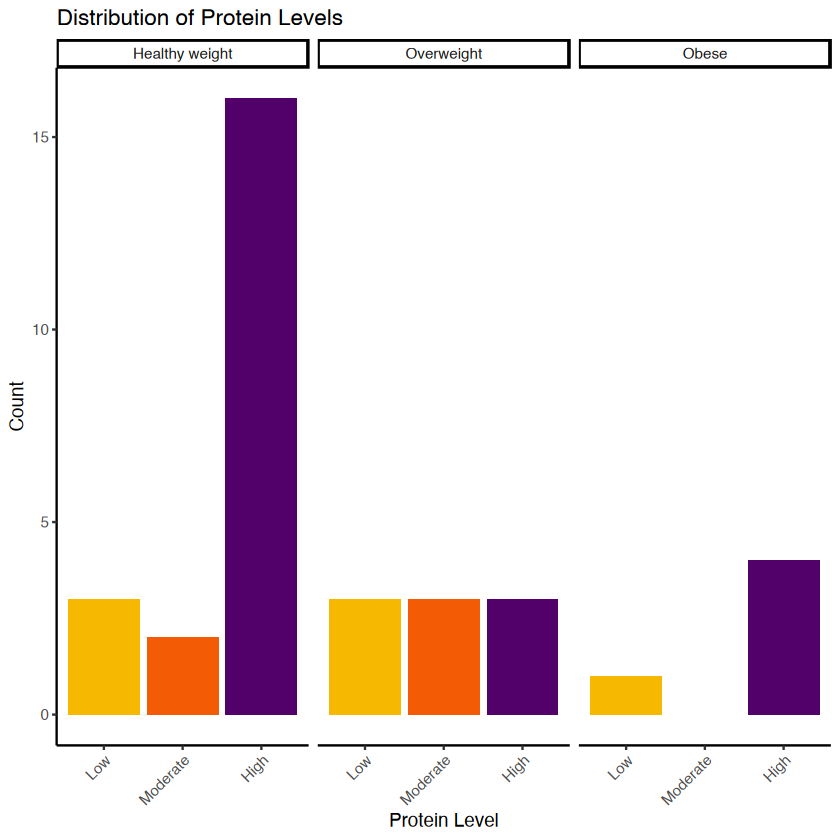

In [38]:
ggplot(metadata, aes(x = Protein_Level, fill = Protein_Level)) +
  geom_bar() +
  theme_classic() +
  labs(
    title = "Distribution of Protein Levels",
    x = "Protein Level",
    y = "Count"
  ) +
  scale_fill_manual(values = c('Low' = '#f7b801',  
                                'Moderate' = '#f35b04', 
                                'High' = '#52006A')) +
  facet_wrap(~BMI_ordinal) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "none"
  )

### Step 4: Assign Taxonomy to our Sequencing Data

We will be using the package `phyloseq` to analyze our microbiomes.

In [41]:
# Install and load libraries
if (!requireNamespace("phyloseq", quietly = TRUE)) {
    install.packages("phyloseq")
}
if (!requireNamespace("ggpubr", quietly = TRUE)) {
    install.packages("ggpubr")
}



library(phyloseq)
library(ggpubr)

In [42]:
# Assigning taxonomy
ps <- phyloseq(otu_table(reads, taxa_are_rows = F),
               tax_table(taxa),
               sample_data(metadata))

ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1613 taxa and 29 samples ]
sample_data() Sample Data:       [ 29 samples by 1114 sample variables ]
tax_table()   Taxonomy Table:    [ 1613 taxa by 7 taxonomic ranks ]

In [ ]:
write.table(otu_table(reads, taxa_are_rows = F), 
            "ASV_table.txt", row.names = TRUE, quote = FALSE, sep = '\t')

### Step 5: Data Analysis and Visualization 

#### Rarefaction Curves

Rarefaction curves are essential tools in microbiome analysis used to assess the richness of microbial communities and the adequacy of sequencing depth. These curves plot the number of observed species against the number of sequencing reads, providing insight into species diversity within a sample.

The shape of a rarefaction curve indicates whether sequencing captured the community’s full diversity: a plateau suggests that most species have been identified, while a steep incline indicates that additional sequencing may uncover more species. Rarefaction also enables comparisons across samples with varying sequencing depths, ensuring that observed differences in diversity are not artifacts of unequal sampling effort.

Let's start by looking at the differences between sex and protein intake.

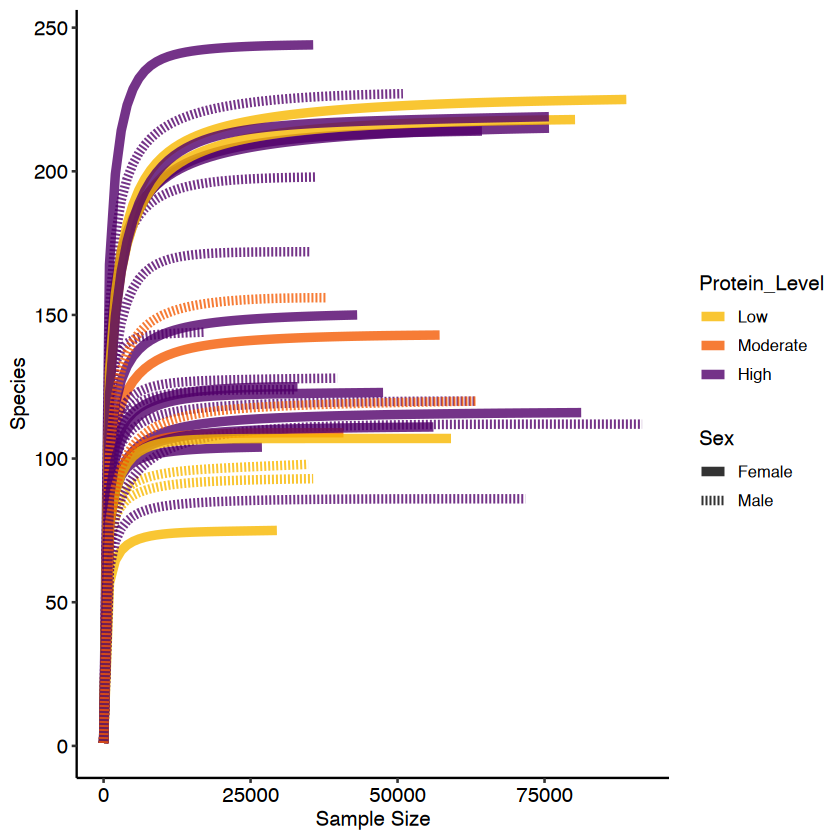

In [44]:
rare <- rarecurve(reads,step = 1000, tidy = TRUE)
rare <- inner_join(rare, metadata, by=c("Site"="SampleID"))

ggplot(rare, aes(x=Sample, y=Species, col=Protein_Level, linetype=Sex, group=Site))+
  geom_line(linewidth = 2, alpha = 0.8)+
  scale_color_manual(values = c('Low' = '#f7b801',  
                                'Moderate' = '#f35b04', 
                                'High' = '#52006A')) +
  theme_pubr(legend="right") +
  labs(x="Sample Size")

Now let's plot BMI and protein intake.

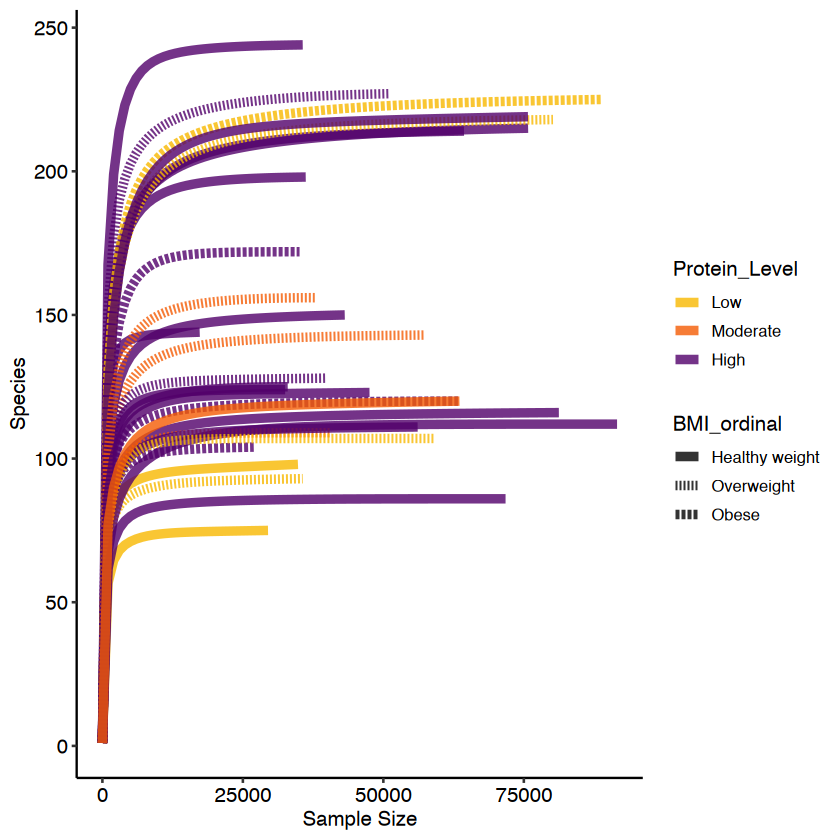

In [45]:
ggplot(rare, aes(x=Sample, y=Species, col=Protein_Level, linetype=BMI_ordinal, group=Site))+
  geom_line(linewidth = 2, alpha = 0.8) +
  scale_color_manual(values = c('Low' = '#f7b801',  
                                'Moderate' = '#f35b04', 
                                'High' = '#52006A')) +
  theme_pubr(legend="right") +
  labs(x="Sample Size")

#### Diversity in Microbiome

Alpha and beta diversity are key concepts in microbiome studies used to understand the composition of microbial communities.
 - **Alpha diversity** refers to the diversity within a single sample, capturing the richness (number of species) and evenness (distribution of species). It provides insights into how diverse a community is at a specific site or condition. Common metrics include species richness, Simpson’s index, and the Shannon index.
 - **Beta diversity**, on the other hand, measures the variation in microbial communities between samples. It highlights differences in composition and can reveal patterns of microbial distribution across environments or conditions. Common beta diversity metrics include Bray-Curtis dissimilarity and UniFrac distances.

##### Alpha Diversity

Let's look at the alpha diversity in our samples with the **Shannon index**. The Shannon index measures both the richness and evenness of species within a sample. A higher Shannon index indicates greater diversity, while a value of 0 means only one species is present in the community.

In [47]:
shannon <- diversity(reads, index = "shannon") %>%
  as_tibble(rownames = "SampleID")%>%
  inner_join(., metadata, by="SampleID")

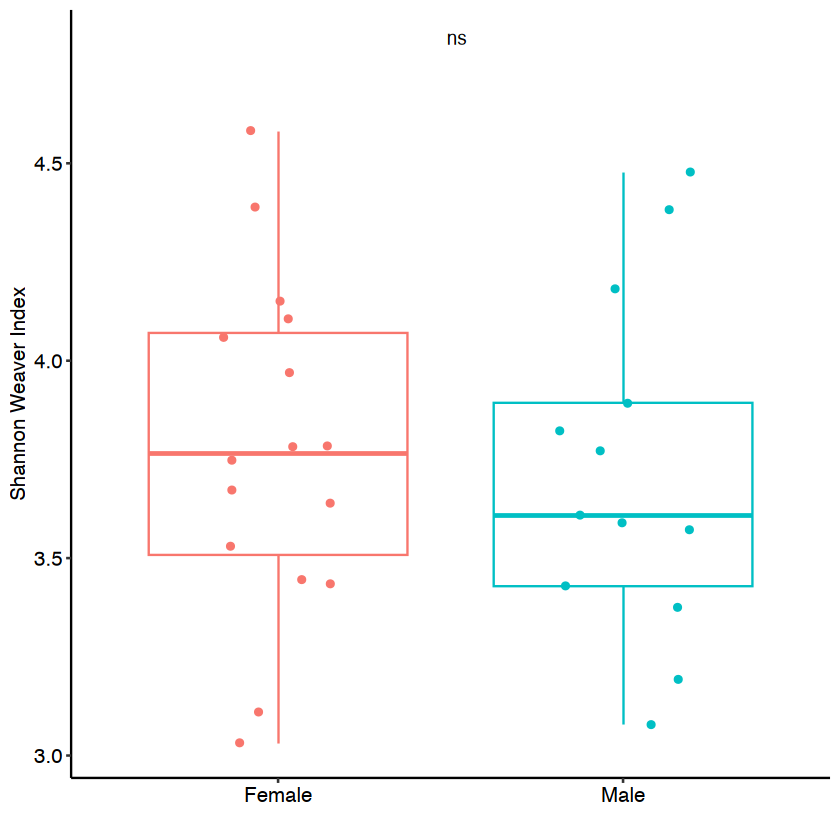

In [48]:
ggplot(shannon, aes(x=Sex, y=value, col=Sex))+
  geom_boxplot(outlier.shape = NA)+
  geom_jitter(width = 0.2) +
  theme_pubr(legend="right") +
  labs(x="",y="Shannon Weaver Index") +
  stat_compare_means(aes(x=Sex, y=value, col=Sex), hide.ns = F, method="t.test",label = "p.signif",
                     label.x = 1.5, label.y= 4.8, show.legend = F) +
  theme(legend.position="none")

Let's look at BMI within sex.

In [49]:
# Instal and load ggstance for better visualization
if (!requireNamespace("ggstance", quietly = TRUE)) {
    install.packages("ggstance")
}


library(ggstance)


Attaching package: ‘ggstance’


The following objects are masked from ‘package:ggplot2’:

    GeomErrorbarh, geom_errorbarh




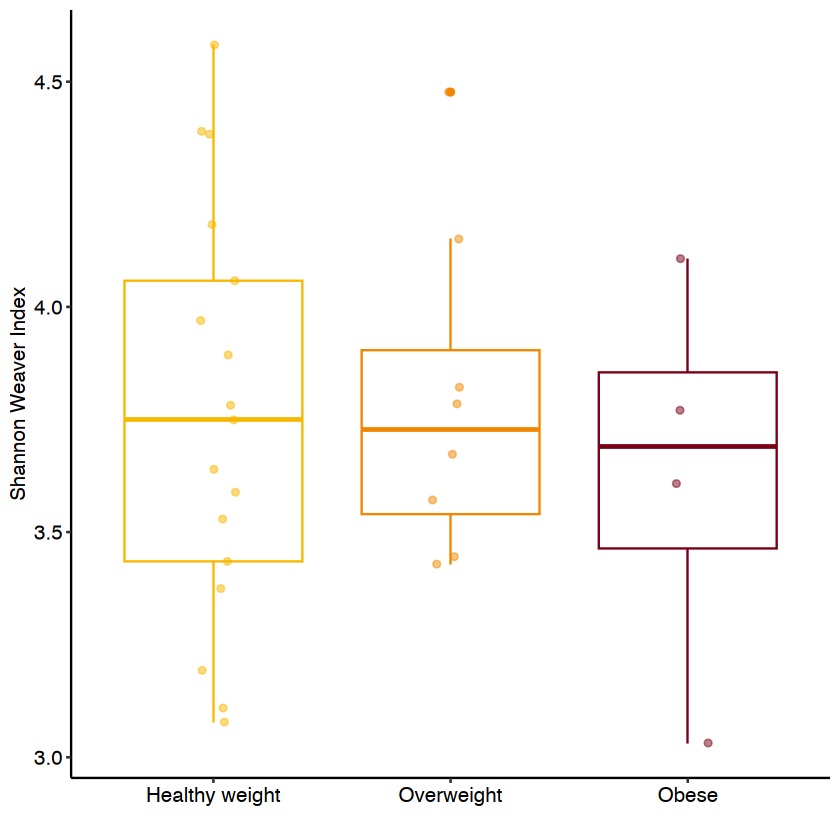

In [50]:
ggplot(shannon, aes(x=BMI_ordinal, y=value, col=BMI_ordinal))+
  geom_boxplot()+  
  geom_jitter(position = position_jitterdodge(jitter.width = 0.5, dodge.width = 0.5), alpha=0.5) +     
  scale_color_manual(values = c('Healthy weight' = '#f7b801', 'Overweight' = '#f18701', 
                                'Obese' = '#780116')) +
  theme_pubr(legend="right") +
  labs(x="",y="Shannon Weaver Index") +
  theme(legend.position="none")

What about alpha diversity by protein intake?

In [ ]:
ggplot(shannon, aes(x=Protein_Level, y=value, col=Protein_Level))+
  geom_boxplot()+  
  geom_jitter(position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), alpha=0.5) +     
  scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  theme_pubr(legend="right") +
  labs(x="",y="Shannon Weaver Index") +
  theme(legend.position="none")

Let's now look at the combination of sex or BMI by protein intake. 

In [ ]:
ggplot(shannon, aes(x=Sex, y=value, col=Protein_Level))+
  geom_boxplot()+ 
  geom_jitter(position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), alpha=0.5) +     
  facet_grid(col=vars(Sex), scales = "free_x")+
  scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  theme_pubr(legend="right") +
  labs(x="",y="Shannon Weaver Index") 

In [ ]:
ggplot(shannon, aes(x=BMI_ordinal, y=value, col=Protein_Level))+
  geom_boxplot()+   
  geom_jitter(position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), alpha=0.5) + 
  facet_grid(col=vars(BMI_ordinal), scales = "free_x")+
  scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  theme_pubr(legend="right") +
  labs(x="",y="Shannon Weaver Index") 

Next, let's look at the alpha diversity with the **Inverse Simpson Index**. The Inverse Simpson Index reflects both species richness and evenness within a community. It accounts for the number of species present and their relative abundances, emphasizing the dominance of common species. A higher Inverse Simpson value indicates greater diversity, as it signifies more species evenly distributed in the community. This index is particularly useful for understanding community composition and detecting dominance patterns in microbiome studies. We will focus on our experimental questions, looking at the combination of variables. 

In [ ]:
invsimp<-diversity(reads, index = "invsimpson")%>%
  as_tibble(rownames = "SampleID")%>%
  inner_join(., metadata, by="SampleID")

In [ ]:
ggplot(invsimp, aes(x=Sex, y=value, col=Protein_Level))+
  geom_boxplot()+ 
  geom_jitter(position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), alpha=0.5) +     
  facet_grid(col=vars(Sex), scales = "free_x")+
  scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  theme_pubr(legend="right") +
  labs(x="",y="Inverse Simpson Index") 


In [ ]:
ggplot(invsimp, aes(x=BMI_ordinal, y=value, col=Protein_Level))+
  geom_boxplot()+ 
  geom_jitter(position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), alpha=0.5) +     
  facet_grid(col=vars(BMI_ordinal), scales = "free_x")+
  scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  theme_pubr(legend="right") +
  labs(x="",y="Inverse Simpson Index") 

##### Beta Diversity

Non-metric Multidimensional Scaling (NMDS) is an ordination method used to visualize differences in community composition between samples, making it a key tool for analyzing beta diversity. It represents pairwise dissimilarities (e.g., Bray-Curtis distances) in a low-dimensional space, preserving the rank order of distances rather than their exact values.

The result is a visual representation where samples with similar microbial communities appear closer together, while dissimilar communities are farther apart. NMDS is particularly useful for identifying patterns and grouping structures in complex ecological or microbiome datasets. The quality of the ordination is assessed using a stress value, with lower values indicating a better representation of the original data.

In [ ]:
# Transform data to proportions as appropriate for Bray-Curtis distances
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
ord.nmds.bray <- ordinate(ps.prop, method="NMDS", distance="bray")

# Plot beta diversity                                   
plot_ordination(ps.prop, ord.nmds.bray, color="Sex", title="Bray NMDS") + theme_pubr(legend="right")

Let's also view by BMI and protein intake.

In [ ]:
plot_ordination(ps.prop, ord.nmds.bray, color="BMI_ordinal", title="Bray NMDS") + scale_color_manual(values = c('Healthy weight' = '#f7b801', 'Overweight' = '#f18701', 
                                'Obese' = '#780116')) + theme_pubr(legend="right")

In [ ]:
plot_ordination(ps.prop, ord.nmds.bray, color="Protein_Level", title="Bray NMDS") +
scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  theme_pubr(legend="right")

Next, we will explore the distribution of taxa at the phylum level across our samples using three different datasets: the full dataset, the proportion-transformed dataset, and the subset of the top 20 most abundant taxa. Visualizing these datasets will allow us to examine the overall microbial composition, highlight differences in relative abundance, and focus on the most dominant taxa within the community.

In [ ]:
# Creating top 20 most abundant
top20    <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20]
ps.top20 <- prune_taxa(top20, ps.prop)

# Plotting by Sex
plot_bar(ps, x="SampleID", fill="Phylum") + facet_wrap(~Sex, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))
plot_bar(ps.prop, x="SampleID", fill="Phylum") + facet_wrap(~Sex, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))
plot_bar(ps.top20, x="SampleID", fill="Phylum") + facet_wrap(~Sex, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))

In [ ]:
# Plotting by BMI
plot_bar(ps, x="SampleID", fill="Phylum") + facet_wrap(~BMI_ordinal, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))
plot_bar(ps.prop, x="SampleID", fill="Phylum") + facet_wrap(~BMI_ordinal, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))
plot_bar(ps.top20, x="SampleID", fill="Phylum") + facet_wrap(~BMI_ordinal, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))

In [ ]:
# Plotting by protein intake
plot_bar(ps, x="SampleID", fill="Phylum") + facet_wrap(~Protein_Level, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))
plot_bar(ps.prop, x="SampleID", fill="Phylum") + facet_wrap(~Protein_Level, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))
plot_bar(ps.top20, x="SampleID", fill="Phylum") + facet_wrap(~Protein_Level, scales="free_x") + theme_bw() +  theme(axis.text.x =element_text(angle=90))

Now, we will focus on a single phylum of interest, *Firmicutes*, to examine its distribution across our study participants. By extracting this specific phylum, we can explore how its relative abundance varies across key categories such as sex, BMI levels, and protein intake. This detailed investigation will provide insights into potential associations between this microbial group and individual characteristics, helping us better understand the role this phylum may play in the overall microbiome composition.

In [ ]:
# Group data at Phylum level - combines ASVs belonging to same phylum
ps.phylum <- tax_glom(ps.prop, taxrank = "Phylum")

# Convert phyloseq object to long format dataframe for easier manipulation
dat <- psmelt(ps.phylum)

# Find rows where Phylum is "Firmicutes"
idx.keep <- which(dat$Phylum == "Firmicutes")

# Create new dataframe with only Firmicutes data
Firmicutes <- dat[idx.keep,]

# Count number of Firmicutes observations to verify subsetting worked
table(Firmicutes$Phylum)

In [ ]:
# Plot
ggplot(Firmicutes)+
  geom_col(aes( x=Sample,y=Abundance, fill=Phylum), position="dodge")+
  facet_grid(col=vars(Protein_Level), space="free_x",scales="free")+
  scale_fill_manual(values =  c('#780116')) +
  labs(title = "Abundance by Protein Level") +
  theme_bw() +
  theme(axis.text.x =element_text(angle=90)
  ) 

We can now use a Kruskal-Wallis test to determine if there are different amounts of *Firmicutes* by protein intake.

In [ ]:
# Create comparison groups 
my_comparisons <- list( c("Low", "Moderate"), c("High", "Low"), c("Moderate", "High") )

# Plot
ggplot(Firmicutes, aes(x=Protein_Level,y=Abundance, fill = Protein_Level, color = Protein_Level))+
  geom_boxplot(outlier.shape = NA, alpha = 0.5) +
  geom_jitter(width = 0.2, size = 2, alpha = 0.8) +
  scale_color_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  scale_fill_manual(values = c('Low' = '#f7b801', 'Moderate' = '#f18701', 
                                'High' = '#780116')) +
  stat_compare_means(comparisons = my_comparisons, label.y = c(1, 1.2, 1.1))+
  stat_compare_means(label.y = 1.3) +
  labs(title = "Firmicutes Abundance by Protein Intake", x = "Protein Intake", y = "Firmicutes Abundance") +
  theme_classic() +
  theme(legend.position = "none")


It seems there is no significant difference in *Firmicutes* abundance between levels of protein intake. 

#### Discussion of Results
This study sought to investigate how dietary patterns, particularly protein intake, and external factors like sex and BMI influence gut microbiome diversity and composition. By examining alpha and beta diversity across these variables, we aimed to uncover meaningful relationships that could shed light on the dynamic interplay between diet, physiology, and microbial communities.

Despite our hypotheses, the findings did not reveal significant differences in microbiome diversity or composition between levels of protein intake, sex, or BMI. The lack of observable trends suggests that these factors may not independently drive major shifts in the microbiome, or that their influence is subtle and requires larger sample sizes to overcome individual variation. It is also possible that interactions among dietary components or unmeasured lifestyle factors play a more significant role, emphasizing the complexity of the diet-microbiome relationship.

Although no clear patterns emerged, these findings highlight the need to further investigate the multifactorial influences on the microbiome to better understand its variability. Future research should consider broader dietary patterns, such as fiber and fat intake, as well as longitudinal approaches to capture temporal shifts in microbial communities. Investigating additional environmental and genetic factors could also provide deeper insights into the interactions shaping the gut microbiome.

Ultimately, while our exploration did not confirm our hypotheses, it underscores the complexity of microbiome research and the intricate interactions between diet, physiology, and lifestyle. This module, designed as a training exercise using a subset of data from a larger study, highlights the importance of refining research questions and methodologies in this evolving field. We hope this serves as a foundation for learners to better understand how to analyze and interpret microbiome data, providing context for future studies and reserch.

## Quiz

In [ ]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./questions/Quiz_Submodule3.html" width=100% height=250></iframe>')

---------------------------------------------------

## Conclusion
In this module, we successfully explored taxonomic classification and diversity analysis using microbiome sequencing data. By integrating dietary and lifestyle metadata with sequencing results, we evaluated the diversity within and between microbial communities. We analyzed alpha diversity using indices such as Shannon and Inverse Simpson to understand richness and evenness, and beta diversity through Non-metric Multidimensional Scaling to assess community composition differences. Additionally, we visualized microbial composition at various taxonomic levels and identified significant associations, such as the relationship between protein intake and *Firmicutes* abundance. These analyses provide a foundation for understanding how diet and other factors influence microbiome composition and diversity.

## Clean up
Please remember to shut down your Sagemaker instance. <br><br>

<br>